In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


2022-04-27 09:14:18.349802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 09:14:18.349825: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

2022-04-27 09:14:19.309019: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 09:14:19.343227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 09:14:19.343349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-27 09:14:19.343447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared obj

# Provision 737 Camera Data Pre-Processing

In [3]:
# Benign traffic

p7_benign = pd.read_csv('../nbaiot/Provision_PT_737E_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_p7_benign = p7_benign.copy(deep=True)

columns = list(df_p7_benign.columns)
chosen_columns = []
for column in columns:
    if column.find('L5') != -1:
        chosen_columns.append(column)
        
df_p7_benign = pd.DataFrame(df_p7_benign, columns = chosen_columns)  

# Mirai

p7_mirai_ack = pd.read_csv('../nbaiot/Provision_PT_737E_Security_Camera/mirai/ack.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_ack = p7_mirai_ack.copy(deep=True)
df_p7_mirai_ack = pd.DataFrame(df_p7_mirai_ack, columns = chosen_columns)  

p7_mirai_scan = pd.read_csv('../nbaiot/Provision_PT_737E_Security_Camera/mirai/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_scan = p7_mirai_scan.copy(deep=True)
df_p7_mirai_scan = pd.DataFrame(df_p7_mirai_scan, columns = chosen_columns)

p7_mirai_syn = pd.read_csv('../nbaiot/Provision_PT_737E_Security_Camera/mirai/syn.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_syn = p7_mirai_syn.copy(deep=True)
df_p7_mirai_syn = pd.DataFrame(df_p7_mirai_syn, columns = chosen_columns)

p7_mirai_udp = pd.read_csv('../nbaiot/Provision_PT_737E_Security_Camera/mirai/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_udp = p7_mirai_udp.copy(deep=True)
df_p7_mirai_udp = pd.DataFrame(df_p7_mirai_udp, columns = chosen_columns)

p7_mirai_udpplain = pd.read_csv('../nbaiot/Provision_PT_737E_Security_Camera/mirai/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_udpplain = p7_mirai_udpplain.copy(deep=True)
df_p7_mirai_udpplain = pd.DataFrame(df_p7_mirai_udpplain, columns = chosen_columns)

# Bashlite

p7_bashlite_combo = pd.read_csv('../nbaiot/Provision_PT_737E_Security_Camera/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_combo = p7_bashlite_combo.copy(deep=True)
df_p7_bashlite_combo = pd.DataFrame(df_p7_bashlite_combo, columns = chosen_columns)

p7_bashlite_junk = pd.read_csv('../nbaiot/Provision_PT_737E_Security_Camera/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_junk = p7_bashlite_junk.copy(deep=True)
df_p7_bashlite_junk = pd.DataFrame(df_p7_bashlite_junk, columns = chosen_columns)

p7_bashlite_scan = pd.read_csv('../nbaiot/Provision_PT_737E_Security_Camera/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_scan = p7_bashlite_scan.copy(deep=True)
df_p7_bashlite_scan = pd.DataFrame(df_p7_bashlite_scan, columns = chosen_columns)

p7_bashlite_udp = pd.read_csv('../nbaiot/Provision_PT_737E_Security_Camera/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_udp = p7_bashlite_udp.copy(deep=True)
df_p7_bashlite_udp = pd.DataFrame(df_p7_bashlite_udp, columns = chosen_columns)

p7_bashlite_tcp = pd.read_csv('../nbaiot/Provision_PT_737E_Security_Camera/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_tcp = p7_bashlite_tcp.copy(deep=True)
df_p7_bashlite_tcp = pd.DataFrame(df_p7_bashlite_tcp, columns = chosen_columns)

In [4]:
scaler = MinMaxScaler()
df_p7_benign_norm = scaler.fit_transform(df_p7_benign)

df_p7_miraiack_norm = scaler.fit_transform(df_p7_mirai_ack)
df_p7_miraiscan_norm = scaler.fit_transform(df_p7_mirai_scan)
df_p7_miraisyn_norm = scaler.fit_transform(df_p7_mirai_syn)
df_p7_miraiudp_norm = scaler.fit_transform(df_p7_mirai_udp)
df_p7_miraiudpplain_norm = scaler.fit_transform(df_p7_mirai_udpplain)

df_p7_bashlitecombo_norm = scaler.fit_transform(df_p7_bashlite_combo)
df_p7_bashlitejunk_norm = scaler.fit_transform(df_p7_bashlite_junk)
df_p7_bashlitescan_norm = scaler.fit_transform(df_p7_bashlite_scan)
df_p7_bashliteudp_norm = scaler.fit_transform(df_p7_bashlite_udp)
df_p7_bashlitetcp_norm = scaler.fit_transform(df_p7_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_p7_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_p7_benign_norm[:len_benign_train]

# Test set - 30% benign and the rest is attack

X_test_benign = df_p7_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_mirai_ack = df_p7_miraiack_norm
X_test_mirai_scan = df_p7_miraiscan_norm
X_test_mirai_syn = df_p7_miraisyn_norm
X_test_mirai_udp = df_p7_miraiudp_norm
X_test_mirai_udpplain = df_p7_miraiudpplain_norm
X_test_bashlite_combo = df_p7_bashlitecombo_norm
X_test_bashlite_junk = df_p7_bashlitejunk_norm
X_test_bashlite_scan = df_p7_bashlitescan_norm
X_test_bashlite_tcp = df_p7_bashlitetcp_norm
X_test_bashlite_udp = df_p7_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_mirai_ack, X_test_mirai_scan, X_test_mirai_syn, X_test_mirai_udp,
                             X_test_mirai_udpplain, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 300
learning_rate = 0.0001
batch_size = 32
anomaly_threshold = 0.035
number_features = 23

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 23)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 11)           264         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 7)            84          ['dense[0][0]']                  
                                                                                                  
 z_var (Dense)                  (None, 7)            84          ['dense[0][0]']                  
                                                                                            

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 11)                88        
                                                                 
 dense_2 (Dense)             (None, 23)                276       
                                                                 
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 23)]              0         
                                                                 
 encoder (Functional)        (None, 7)                 432       
                                                                 
 decoder (Functional)        (None, 23)                364       
                                                                 
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 43507 samples
Epoch 1/300


2022-04-27 09:14:28.269465: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


43507/43507 [==============================] - 3s 65us/sample - loss: 103.5833
Epoch 2/300
43507/43507 [==============================] - 3s 66us/sample - loss: 27.5713
Epoch 3/300
43507/43507 [==============================] - 3s 63us/sample - loss: 10.2066
Epoch 4/300
43507/43507 [==============================] - 2s 54us/sample - loss: 8.1860
Epoch 5/300
43507/43507 [==============================] - 2s 54us/sample - loss: 7.3039
Epoch 6/300
43507/43507 [==============================] - 2s 53us/sample - loss: 6.6714
Epoch 7/300
43507/43507 [==============================] - 2s 54us/sample - loss: 6.0385
Epoch 8/300
43507/43507 [==============================] - 2s 54us/sample - loss: 5.5539
Epoch 9/300
43507/43507 [==============================] - 2s 53us/sample - loss: 5.2162
Epoch 10/300
43507/43507 [==============================] - 2s 53us/sample - loss: 4.9747
Epoch 11/300
43507/43507 [==============================] - 2s 54us/sample - loss: 4.7538
Epoch 12/300
43507/43507 [=

43507/43507 [==============================] - 1s 33us/sample - loss: 2.2358
Epoch 183/300
43507/43507 [==============================] - 1s 33us/sample - loss: 2.2478
Epoch 184/300
43507/43507 [==============================] - 1s 34us/sample - loss: 2.2517
Epoch 185/300
43507/43507 [==============================] - 1s 33us/sample - loss: 2.2482
Epoch 186/300
43507/43507 [==============================] - 2s 35us/sample - loss: 2.2270
Epoch 187/300
43507/43507 [==============================] - 2s 35us/sample - loss: 2.2406
Epoch 188/300
43507/43507 [==============================] - 2s 35us/sample - loss: 2.2225
Epoch 189/300
43507/43507 [==============================] - 2s 35us/sample - loss: 2.2359
Epoch 190/300
43507/43507 [==============================] - 2s 35us/sample - loss: 2.2658
Epoch 191/300
43507/43507 [==============================] - 1s 34us/sample - loss: 2.2140
Epoch 192/300
43507/43507 [==============================] - 2s 35us/sample - loss: 2.2480
Epoch 193/300

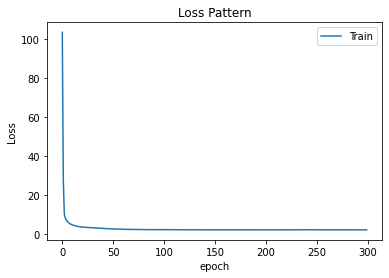

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold
#np.quantile(error_vector, anomaly_threshold)

print(error_thresh)

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.035


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 26.46264362335205
[False False False ...  True  True  True]


0.9789411445384726

In [15]:
print(len(X_test_VAE))

784753


## Metrics

In [16]:
sys.stdout = open("../Results/P737_camera.txt", "a")

print(" ==== Test " + str(number_features) + " Normal learning rate ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))

In [17]:
'''# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)'''

'# Examinig the latent space generated by the encoder\n\nX_encoded = encoder.predict(X_test_VAE)\n\npca = PCA(n_components=2)\nX_analysis = pca.fit_transform(X_encoded)'

In [18]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)\nplt.grid()\nplt.show()\n\n# Darker clusters indicate that the error is higher'

In [19]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)\nplt.grid()\nplt.show()\n\n# Orange ones are anomalies'

In [20]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)\nplt.grid()\nplt.show()\n\n# Ground truth'